# 0.Assignments

👾 這個陽春的聊天機器人需要被優化！<br>
若是一個對話串不間斷地持續進行，送進去的訊息量會很多，tokens數量也會跟著增加，會需要花比較多費用(💸💸💸)，也可能使模型的回應雜訊比較多而回應受到干擾，所以我們可以優化短期記憶。<br>
另外，我們希望優化使用者體驗，我們可以根據聊天的內容整理出使用者的屬性，並在每一次跟使用者聊天時，都能根據這個使用者的狀況給予客製化的回應，因此我們要加入長期記憶的功能！

<br>

### 1. 短期記憶優化

(1) 🔰 [基本版] 在短期記憶中，將chatbot node送入llm的訊息中加入trim的優化機制 (依據適當的tokens數量決定)


<br>

### 2. 加入長期記憶

加入長期記憶，讓聊天機器人能夠記住使用者的資訊（名字、偏好語言、興趣），在下一次對話也能針對同個使用者的資訊，給予個人化的回答。

(1) 🔰 [基本版]
- chatbot node: 在chatbot node中，將該使用者的資訊取出，讓入prompt中讓llm依據使用者的資訊給予個人化的回答

- write_memory node: 在每一次生成回答後，將使用者的資訊整理成一段對使用者的描述(使用llm，給予system prompt做指引，自行設計如何整理、需要整理哪些資訊)，將整理完的資訊整理到store (可跨threads存取的地方)。

- config: config從原本的短期記憶只有thread_id, 也要加入user_id

<img src="https://drive.google.com/uc?export=view&id=1H4Y0WplOi6R4Eo06Ac2JA_9TbZa2YaRD" width="100"/>


(2) 👨‍🎓 [進階版]
- chatbot node: 可以決定使用者的問題是否需要從長期記憶中取得資訊，以及需要取得什麼資訊
- write_memory node: 可以整理成特定格式 (例如：使用with_structured_output，相關概念可以延伸到R3 tool calling內容)。例如：
```
user_profile = {
  "first_name": "XXXX",
  "last_name": "OOO",
  "preferred_lang": ["en", "zh-tw"]
}
```
- 也可以自行將graph結構調整自己喜歡的(增刪不同node, conditional router, ...)
- 要使用有支援function calling的模型：MediaTek-Research/Breeze-7B-FC-v1_0


<br>
備註：基本版是需要大家完成的，進階版可以自行決定是否挑戰，Enjoy the ride! 😎

# 1.短期記憶

## (1) 基本版
🔰 [基本版] 在短期記憶中，將chatbot node送入llm的訊息中加入trim的優化機制 (依據適當的tokens數量決定)

note: 可以邊做邊看一下trim設定的效果以及內部運作的機制

In [1]:
%%capture --no-stderr
!pip install -U langgraph langchain_openai==0.3.15 langchain transformers bitsandbytes langchain-huggingface

In [2]:
%%capture --no-stderr
# 使用local模型
# 會需要一點時間
# 記得將runtime調到T4 GPU (runtime -> change runtime type)
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline, BitsAndBytesConfig
from langchain_huggingface import HuggingFacePipeline

# 使用 4-bit 量化模型
model_id = "MediaTek-Research/Breeze-7B-Instruct-v1_0"

quant_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
    llm_int8_threshold=6.0,
)

# 載入 tokenizer 與 4-bit 模型
tokenizer = AutoTokenizer.from_pretrained(model_id, use_fast=True)
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    device_map="auto",
    quantization_config=quant_config,
    trust_remote_code=True
)

In [3]:
# 建立 text generation pipeline
generator = pipeline(
    task="text-generation",
    model=model,
    tokenizer=tokenizer,
    max_new_tokens=512,
    do_sample=True,
    temperature=0.4,
    return_full_text=False # 僅返回生成的回應內容
)

# 包裝成 LangChain 的 llm 物件
llm_local = HuggingFacePipeline(pipeline=generator)

Device set to use cuda:0


In [4]:
import os
from google.colab import userdata

os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')

In [5]:
from langchain_openai import ChatOpenAI
llm_api = ChatOpenAI(model="gpt-4o-mini")  # 你可以換成 "gpt-4" 或其他 OpenAI 模型名稱


In [6]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_core.messages import convert_to_openai_messages, SystemMessage, HumanMessage, AIMessage, BaseMessage
from langchain_core.messages.utils import trim_messages, count_tokens_approximately # 將 trim 加入 Annotated metadata 中，設定最大 token 數量（例如 1000）
from langgraph.checkpoint.memory import MemorySaver

class State(TypedDict):
  messages: Annotated[list, add_messages]

def chatbot(state: State, mode="local"):
  trimed_messages = trim_messages(
      include_system=True,
      messages=state["messages"],
      strategy="last",
      token_counter=count_tokens_approximately,
      max_tokens=100,
      start_on="human",
      end_on=("human", "tool"),
      )
  system_prompt = "你是個只能使用繁體中文回答的助理"
  if mode == "local":
    messages = convert_to_openai_messages(trimed_messages) # Convert LangChain messages into OpenAI message dicts.
    system_message =  [{"role": "system", "content": system_prompt}]
    # apply tokenizer prompt template
    prompt = tokenizer.apply_chat_template(
        system_message+messages,
        tokenize=False,
        add_generation_prompt=True
    )
    response = llm_local.invoke(prompt)
    return {"messages": [AIMessage(content=response)]}
  elif model == "api":
    system_message = [SystemMessage(content=system_prompt)]
    response = llm_api.invoke(system_message+trimed_messages)
    return {"messages": [response]}


# 建立graph
graph_builder = StateGraph(State)
graph_builder.add_node("chatbot", chatbot) # 在graph裡面加入chatbot的node
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)

# 加入短期記憶
memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)


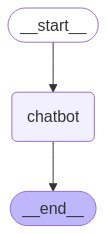

In [7]:
# 看一下graph
from IPython.display import Image, display

try:
  display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
  print(e)
  pass

In [8]:
def stream_graph_updates(user_input: str, config: dict):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}], "mode":"api"}, config):
      if "chatbot" in event:
        for value in event.values():
          print("Assistant:", value["messages"][-1].content)

In [9]:
# 設定對話config (第一次對話)
config = {"configurable": {"thread_id": "conversation_1"}} # thread_id: 對話id

In [11]:
# 開始對話 (可以輸入quit, exit, q，三選一停止對話)
while True:
  try:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
      print("Goodbye!")
      break
    stream_graph_updates(user_input, config)
  except Exception as e:
    print(e)
    break

User: 我是小明
Assistant: 你好，小明！如果你有任何問題或需要幫助，請不要猶豫，隨時告訴我。
User: 我喜歡打籃球
Assistant: 太好了，小明！打籃球是一種有趣且健康的運動。籃球可以鍛鍊你的體能、協調性、敏捷性，以及團隊合作的能力。如果你想提高你的籃球技巧，以下是一些建議：

1. 練習基本動作：加強基本動作如投籃、運球、傳球、防守等，這些基本動作是成功的關鍵。
2. 加強體能：保持良好的體能有助於你在比賽中保持活力，跑動、跳投、防守等動作更流暢。
3. 團隊合作：籃球是團隊運動，學習與隊友溝通、相互支持，以及在比賽中彼此鼓勵，有助於提升團隊合作能力。
4. 觀看比賽：研究職業或業餘比賽的影片，可以學到很多技巧和策略。
5. 多練習：經常練習，才能在比賽中發揮出最好的表現。

如果你有任何其他問題或需要幫助，請隨時告訴我。
User: 可以介紹一下 nba球星嗎
Assistant: 當然，以下是一些 NBA 球星的介紹：

1. LeBron James：
   NBA 傳奇球星，被譽為 "King James"，他擁有卓越的體能、投籃和傳球能力，是一位多功能的球員。LeBron 在 2003 年被克里夫蘭騎士選中，並多次贏得 NBA 總冠軍。

2. Stephen Curry：
   Stephen Curry 是金州勇士隊的球星，被稱為 "Chef"。他以出色的三分球能力和優異的傳球能力而聞名。Curry 在 2009 年被金州勇士選中，並多次贏得 NBA 總冠軍和最有價值球員 (MVP)。

3. Giannis Antetokounmpo：
   希臘球星 Giannis Antetokounmpo 被稱為 "Greek Freak"。他擁有出色的體能和身高優勢，是一位多功能的球員。Giannis 在 2013 年被密爾瓦基公鹿選中，並多次贏得 NBA 總冠軍和最有價值球員 (MVP)。

4. Kevin Durant：
   Kevin Durant 是一位得分高手，被稱為 "KD"。他擁有出色的投籃和得分能力，多次贏得 NBA 總冠軍和最有價值球員 (MVP)。Kevin 在 2007 年被西雅圖超音速選中，後來被金州勇士隊簽下。

5. James Harden：
   James Harden 是一位得分好手，被稱為

---

## (1) 基本版
🔰 [基本版]
- chatbot node: 在chatbot node中，將該使用者的資訊取出，讓入prompt中讓llm依據使用者的資訊給予個人化的回答

- write_memory node: 在每一次生成回答後，將使用者的資訊整理成一段對使用者的描述(使用llm，給予system prompt做指引，自行設計如何整理、需要整理哪些資訊)，將整理完的資訊整理到store (可跨threads存取的地方)。

- config: config從原本的短期記憶只有thread_id, 也要加入user_id

<img src="https://drive.google.com/uc?export=view&id=1H4Y0WplOi6R4Eo06Ac2JA_9TbZa2YaRD" width="100"/>

In [12]:
%%capture --no-stderr
!pip install langchain_core

In [13]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.checkpoint.memory import MemorySaver
from langgraph.store.memory import InMemoryStore # cross-thread store

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.store.base import BaseStore

from langchain_core.messages import HumanMessage, SystemMessage, AIMessage, BaseMessage
from langchain_core.runnables.config import RunnableConfig


# Chatbot instruction
MODEL_SYSTEM_MESSAGE = """你是一位有記憶功能的助理，請用臺灣繁體中文回答使用者的問題。
如果你對這位使用者有記憶，請利用這些記憶來調整你的回覆。
以下是你的記憶內容（可能為空）：{memory}"""

# Create new memory from the chat history and any existing memory
CREATE_MEMORY_INSTRUCTION = """"你正在收集使用者的資訊，以便個人化回應。

目前的使用者資訊：
{memory}

INSTRUCTIONS:
1. 請仔細閱讀下方的聊天紀錄
2. 辨識關於使用者的新資訊，例如：
  - 個人資料（姓名、地點）
  - 習慣的語言
  - 偏好（喜好、不喜好）
  - 興趣與嗜好
3. 將新資訊與既有記憶整合
4. 使用清楚的項目符號格式呈現記憶內容
5. 如果新資訊與現有記憶衝突，請保留最新版本

**請注意：**僅記錄使用者明確陳述的事實資訊。請勿作出推論或假設。

根據以下的聊天記錄，使用臺灣繁體中文總結最新的使用者資訊，不需要有其他註解：
{conversation}
"""

class State(TypedDict):
  messages: Annotated[list, add_messages]

def chatbot(state: State, mode="local"):
  trimed_messages = trim_messages(
      include_system=True,
      messages=state["messages"],
      strategy="last",
      token_counter=count_tokens_approximately,
      max_tokens=100,
      start_on="human",
      end_on=("human", "tool"),
      )
  system_prompt = "你是個只能使用繁體中文回答的助理"
  if mode == "local":
    messages = convert_to_openai_messages(trimed_messages) # Convert LangChain messages into OpenAI message dicts.
    system_message =  [{"role": "system", "content": system_prompt}]
    # apply tokenizer prompt template
    prompt = tokenizer.apply_chat_template(
        system_message+messages,
        tokenize=False,
        add_generation_prompt=True
    )
    response = llm_local.invoke(prompt)
    return {"messages": [AIMessage(content=response)]}
  elif model == "api":
    system_message = [SystemMessage(content=system_prompt)]
    response = llm_api.invoke(system_message+trimed_messages)
    return {"messages": [response]}


def chatbot(state: State, config: RunnableConfig, store: BaseStore):
  # Get the user ID from the config
  user_id = config["configurable"]["user_id"]

  # Retrieve memory from the store
  namespace = ("memory", user_id)
  key = "user_memory"
  existing_memory = store.get(namespace, key)

  # Extract the actual memory content if it exists and add a prefix
  if existing_memory:
      # Value is a dictionary with a memory key
      existing_memory_content = existing_memory.value.get('memory')
  else:
      existing_memory_content = "No existing memory found."

  # Format the memory in the system prompt
  system_prompt = MODEL_SYSTEM_MESSAGE.format(memory=existing_memory_content)

  system_message = [SystemMessage(content=system_prompt)]
  response = llm_api.invoke(system_message+state["messages"])

  return {"messages": [response]}


def write_memory(state: State, config: RunnableConfig, store: BaseStore):

    """Reflect on the chat history and save a memory to the store."""

    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Retrieve existing memory from the store
    namespace = ("memory", user_id)
    existing_memory = store.get(namespace, "user_memory")

    # Extract the memory
    if existing_memory:
        existing_memory_content = existing_memory.value.get('memory')
    else:
        existing_memory_content = "No existing memory found."

    # Format the memory in the system prompt
    system_prompt = CREATE_MEMORY_INSTRUCTION.format(memory=existing_memory_content, conversation="\n".join([message.pretty_repr() for message in state["messages"]]))
    system_message = [SystemMessage(content=system_prompt)]
    new_memory = llm_api.invoke(system_message+state["messages"])
    # prompt = build_prompt_from_messages(state["messages"], tokenizer, system_msg, "memory")

    new_memory = llm_api.invoke(system_prompt)
    print("==== new long-term memory ====:\n", new_memory.text())
    # Overwrite the existing memory in the store
    key = "user_memory"

    # Write value as a dictionary with a memory key
    store.put(namespace, key, {"memory": new_memory.text()})

# Define the graph
builder = StateGraph(State)
builder.add_node("chatbot", chatbot)
builder.add_node("write_memory", write_memory)
builder.add_edge(START, "chatbot")
builder.add_edge("chatbot", "write_memory")
builder.add_edge("write_memory", END)


# Store for long-term (across-thread) memory
across_thread_memory = InMemoryStore()
# Checkpointer for short-term (within-thread) memory
within_thread_memory = MemorySaver()

# Compile the graph with the checkpointer fir and store
graph = builder.compile(checkpointer=within_thread_memory, store=across_thread_memory)


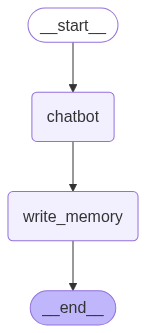

In [14]:
# View
from IPython.display import Image, display

try:
  display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
  print(e)
  pass

In [15]:
def stream_graph_updates(user_input: str, config: dict):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}, config):
        if "chatbot" in event:
          for value in event.values():
            print("Assistant:", value["messages"][-1].content)

In [16]:
# 使用者1的第一次對話
config = {"configurable": {"thread_id": "conversation_1", "user_id": "user_1"}}

In [17]:
# 開始對話 (可以輸入quit, exit, q，三選一停止對話)
while True:
  try:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
      print("Goodbye!")
      break
    stream_graph_updates(user_input, config)
  except Exception as e:
    print(e)
    break

User: 你好
Assistant: 你好！有什麼我可以幫你忙的嗎？
==== new long-term memory ====:
 - 沒有現有的使用者資訊。
User: 我是小明
Assistant: 你好，小明！很高興認識你。今天有什麼想聊的或需要幫忙的嗎？
==== new long-term memory ====:
 - 姓名：小明
- 現居地：暫無資訊
- 習慣的語言：中文
- 偏好：暫無資訊
- 興趣與嗜好：暫無資訊
User: 我喜歡打籃球
Assistant: 太好了！打籃球是一項很有趣又有益健康的運動。你平常會和朋友一起打球嗎？或者有沒有喜歡的球隊或球員呢？
==== new long-term memory ====:
 - 姓名：小明
- 現居地：暫無資訊
- 習慣的語言：中文
- 偏好：暫無資訊
- 興趣與嗜好：喜歡打籃球
User: LBJ 你猜是誰？
Assistant: LBJ 是指勒布朗·詹姆斯（LeBron James），他是一位非常著名的NBA球星，擁有卓越的籃球技藝和全能的表現。你喜歡他哪一方面的表現呢？
==== new long-term memory ====:
 - 姓名：小明
- 現居地：暫無資訊
- 習慣的語言：中文
- 偏好：暫無資訊
- 興趣與嗜好：喜歡打籃球，喜愛勒布朗·詹姆斯（LBJ）
User: q
Goodbye!


In [20]:
across_thread_memory.get(("memory", "user_1"), "user_memory")

Item(namespace=['memory', 'user_1'], key='user_memory', value={'memory': '- 姓名：小明\n- 現居地：暫無資訊\n- 習慣的語言：中文\n- 偏好：暫無資訊\n- 興趣與嗜好：喜歡打籃球，喜愛勒布朗·詹姆斯（LBJ）'}, created_at='2025-06-03T15:21:59.485831+00:00', updated_at='2025-06-03T15:21:59.485837+00:00')

In [21]:
# 使用者A的第二次對話
config = {"configurable": {"thread_id": "conversation_2", "user_id": "user_1"}}

In [22]:
# 開始對話 (可以輸入quit, exit, q，三選一停止對話)
while True:
  try:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
      print("Goodbye!")
      break
    stream_graph_updates(user_input, config)
  except Exception as e:
    print(e)
    break

User: 你記得我喜歡哪一個球星嗎
Assistant: 當然記得，你喜歡勒布朗·詹姆斯（LBJ）。有什麼想聊的關於他嗎？
==== new long-term memory ====:
 - 姓名：小明
- 現居地：暫無資訊
- 習慣的語言：中文
- 偏好：暫無資訊
- 興趣與嗜好：喜歡打籃球，喜愛勒布朗·詹姆斯（LBJ）
User: 我的座標在紐約
Assistant: 謝謝你告訴我！那你現在在紐約生活，應該有很多機會看到籃球比賽和相關活動吧？如果你有任何想討論的話題，隨時告訴我！
==== new long-term memory ====:
 - 姓名：小明
- 現居地：紐約
- 習慣的語言：中文
- 偏好：暫無資訊
- 興趣與嗜好：喜歡打籃球，喜愛勒布朗·詹姆斯（LBJ）
User: q
Goodbye!


In [23]:
# 看一下該使用者的記憶
across_thread_memory.get(("memory", "user_1"), "user_memory")

Item(namespace=['memory', 'user_1'], key='user_memory', value={'memory': '- 姓名：小明\n- 現居地：紐約\n- 習慣的語言：中文\n- 偏好：暫無資訊\n- 興趣與嗜好：喜歡打籃球，喜愛勒布朗·詹姆斯（LBJ）'}, created_at='2025-06-03T15:23:28.963110+00:00', updated_at='2025-06-03T15:23:28.963117+00:00')

## (2) 進階版

👨‍🎓 [進階版]
- chatbot node: 可以決定使用者的問題是否需要從長期記憶中取得資訊，以及需要取得什麼資訊
- write_memory node: 可以整理成特定格式 (例如：使用with_structured_output，相關概念可以延伸到R3 tool calling內容)。例如：
```
user_profile = {
  "first_name": "XXXX",
  "last_name": "OOO",
  "preferred_lang": ["en", "zh-tw"]
}
```
- 也可以自行將graph結構調整自己喜歡的(增刪不同node, conditional router, ...)

In [24]:
from typing import Annotated, List, Optional
from typing_extensions import TypedDict
from pydantic import BaseModel, Field
from langgraph.checkpoint.memory import MemorySaver
from langgraph.store.memory import InMemoryStore
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.store.base import BaseStore
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage, BaseMessage
from langchain_core.runnables.config import RunnableConfig

# 定義用戶檔案的結構化模型
class UserProfile(BaseModel):
    """使用者檔案的結構化表示"""
    first_name: Optional[str] = Field(default=None, description="用戶的名字")
    last_name: Optional[str] = Field(default=None, description="用戶的姓氏")
    preferred_lang: List[str] = Field(default_factory=list, description="偏好的語言，例如 ['zh-tw', 'en']")
    interests: List[str] = Field(default_factory=list, description="興趣和嗜好")
    location: Optional[str] = Field(default=None, description="居住地點或常提及的地點")
    occupation: Optional[str] = Field(default=None, description="職業")
    preferences: List[str] = Field(default_factory=list, description="一般偏好和喜好")
    dislikes: List[str] = Field(default_factory=list, description="不喜歡的事物")
    personal_notes: List[str] = Field(default_factory=list, description="其他個人資訊和備註")

# Chatbot instruction
MODEL_SYSTEM_MESSAGE = """你是一位有記憶功能的助理，請用臺灣繁體中文回答使用者的問題。
如果你對這位使用者有記憶，請利用這些記憶來調整你的回覆。
以下是你的記憶內容：{memory}"""

# Create new memory from the chat history and any existing memory
CREATE_MEMORY_INSTRUCTION = """你正在收集使用者的資訊，以便個人化回應。

目前的使用者檔案：
{existing_profile}

INSTRUCTIONS:
1. 請仔細閱讀下方的聊天紀錄
2. 辨識關於使用者的新資訊，例如：
   - 姓名（first_name, last_name）
   - 偏好語言（preferred_lang）
   - 興趣與嗜好（interests）
   - 居住地點（location）
   - 職業（occupation）
   - 個人偏好（preferences）
   - 不喜歡的事物（dislikes）
   - 其他個人資訊（personal_notes）
3. 將新資訊與既有檔案整合
4. 如果新資訊與現有記憶衝突，請保留最新版本
5. 請用結構化的JSON格式回傳更新後的用戶檔案

**請注意：**僅記錄使用者明確陳述的事實資訊。請勿作出推論或假設。

根據以下的聊天記錄，更新用戶檔案：
{conversation}"""

class State(TypedDict):
    messages: Annotated[list, add_messages]

def format_user_profile_for_display(profile: UserProfile) -> str:
    """將使用者檔案格式化為易讀的字串"""
    lines = []

    if profile.first_name or profile.last_name:
        name_parts = [part for part in [profile.first_name, profile.last_name] if part]
        lines.append(f"姓名: {' '.join(name_parts)}")

    if profile.preferred_lang:
        lines.append(f"偏好語言: {', '.join(profile.preferred_lang)}")

    if profile.location:
        lines.append(f"地點: {profile.location}")

    if profile.occupation:
        lines.append(f"職業: {profile.occupation}")

    if profile.interests:
        lines.append(f"興趣: {', '.join(profile.interests)}")

    if profile.preferences:
        lines.append(f"偏好: {', '.join(profile.preferences)}")

    if profile.dislikes:
        lines.append(f"不喜歡: {', '.join(profile.dislikes)}")

    if profile.personal_notes:
        lines.append(f"其他資訊: {'; '.join(profile.personal_notes)}")

    return '\n'.join(lines) if lines else "暫無使用者資訊"

def chatbot(state: State, config: RunnableConfig, store: BaseStore):
    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Retrieve memory from the store
    namespace = ("memory", user_id)
    key = "user_profile"
    existing_memory = store.get(namespace, key)

    # Extract and format the memory content
    if existing_memory and existing_memory.value:
        try:
            # 嘗試解析為 UserProfile
            profile_data = existing_memory.value
            if isinstance(profile_data, dict):
                user_profile = UserProfile(**profile_data)
            else:
                user_profile = UserProfile()
            memory_content = format_user_profile_for_display(user_profile)
        except Exception as e:
            print(f"Error parsing user profile: {e}")
            memory_content = "記憶格式錯誤，已重置。"
    else:
        memory_content = "暫無使用者記憶。"

    # Format the memory in the system prompt
    system_prompt = MODEL_SYSTEM_MESSAGE.format(memory=memory_content)
    system_message = [SystemMessage(content=system_prompt)]

    response = llm_api.invoke(system_message + state["messages"])

    return {"messages": [response]}

def write_memory(state: State, config: RunnableConfig, store: BaseStore):
    """從聊天記錄中提取資訊並以結構化格式保存記憶"""

    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Retrieve existing memory from the store
    namespace = ("memory", user_id)
    existing_memory = store.get(namespace, "user_profile")

    # Parse existing profile
    if existing_memory and existing_memory.value:
        try:
            if isinstance(existing_memory.value, dict):
                existing_profile = UserProfile(**existing_memory.value)
            else:
                existing_profile = UserProfile()
        except Exception as e:
            print(f"Error parsing existing profile: {e}")
            existing_profile = UserProfile()
    else:
        existing_profile = UserProfile()

    # Format conversation for analysis
    conversation_text = "\n".join([
        f"[{message.type.upper()}]: {message.content}"
        for message in state["messages"]
    ])

    # Create the prompt for memory extraction
    system_prompt = CREATE_MEMORY_INSTRUCTION.format(
        existing_profile=existing_profile.model_dump_json(indent=2, exclude_none=True),
        conversation=conversation_text
    )

    # Get structured output from LLM
    try:
        # 使用結構化輸出 - 根據你的 LLM API 調整
        structured_llm = llm_api.with_structured_output(UserProfile)
        new_profile = structured_llm.invoke([SystemMessage(content=system_prompt)])

        print("==== new long-term memory ====")
        print(new_profile.model_dump_json(indent=2, exclude_none=True))

        # Store the structured profile
        store.put(namespace, "user_profile", new_profile.model_dump(exclude_none=True))

    except Exception as e:
        print(f"結構化記憶提取失敗: {e}")

# Define the graph
builder = StateGraph(State)
builder.add_node("chatbot", chatbot)
builder.add_node("write_memory", write_memory)
builder.add_edge(START, "chatbot")
builder.add_edge("chatbot", "write_memory")
builder.add_edge("write_memory", END)

# Store for long-term (across-thread) memory
across_thread_memory = InMemoryStore()
# Checkpointer for short-term (within-thread) memory
within_thread_memory = MemorySaver()

# Compile the graph with the checkpointer and store
graph = builder.compile(checkpointer=within_thread_memory, store=across_thread_memory)


In [25]:
# 使用者2的第一次對話
config = {"configurable": {"thread_id": "conversation_1", "user_id": "user_2"}}

In [26]:
# 開始對話 (可以輸入quit, exit, q，三選一停止對話)
while True:
  try:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
      print("Goodbye!")
      break
    stream_graph_updates(user_input, config)
  except Exception as e:
    print(e)
    break

User: I'm ruby醬. This is a pen. That is an apple.
Assistant: 嗨，ruby醬！你好啊！看來你在玩一些英語教學的內容呢。這句話有趣又簡單，有別的句子或主題想一起討論嗎？
==== new long-term memory ====
{
  "first_name": "ruby",
  "last_name": "醬",
  "preferred_lang": [],
  "interests": [],
  "preferences": [],
  "dislikes": [],
  "personal_notes": []
}
User: あなたのことが一番好きです
Assistant: 你好，ruby醬！這句日文的意思是「我最喜歡你」。謝謝你的讚美！如果你對日文有興趣或想聊聊其他話題，隨時告訴我哦！
==== new long-term memory ====
{
  "first_name": "ruby",
  "last_name": "醬",
  "preferred_lang": [
    "ja"
  ],
  "interests": [],
  "preferences": [],
  "dislikes": [],
  "personal_notes": []
}
User: 你知道我是誰嗎？
Assistant: 當然，ruby醬！你是我記憶中的使用者。如果有任何特定的問題或者想討論的主題，隨時告訴我！
==== new long-term memory ====
{
  "first_name": "ruby",
  "last_name": "醬",
  "preferred_lang": [
    "ja"
  ],
  "interests": [],
  "preferences": [],
  "dislikes": [],
  "personal_notes": []
}
User: 我是一個知名的歌手喔
Assistant: 哇，ruby醬！你是一位知名的歌手，真令人羨慕！你主要唱什麼類型的音樂呢？或者最近有什麼新作品想跟我分享嗎？
==== new long-term memory ====
{
  "first_name": "ruby",
  "last_n

In [28]:
# 看一下該使用者的記憶
across_thread_memory.get(("memory", "user_2"), "user_profile")

Item(namespace=['memory', 'user_2'], key='user_profile', value={'first_name': 'ruby', 'last_name': '醬', 'preferred_lang': ['ja'], 'interests': [], 'occupation': '知名的歌手', 'preferences': [], 'dislikes': [], 'personal_notes': []}, created_at='2025-06-03T15:25:59.597092+00:00', updated_at='2025-06-03T15:25:59.597096+00:00')